In [1]:
import numpy as np, tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd, os, cv2
import tensorflow as tf, pydicom as dicom
from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.model_selection import train_test_split
import sklearn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BIG_TRAIN = '/kaggle/input/rsna-make-tfrec/train_images'
BIG_VALID = '/kaggle/input/rsna-make-tfrec/valid_images'
MEDIUM_TRAIN = '/kaggle/input/rsna-make-tfrec/mediumtrain_images'
MEDIUM_VALID = '/kaggle/input/rsna-make-tfrec/mediumvalid_images'
SMALL_TRAIN = '/kaggle/input/rsna-make-tfrec/smalltrain_images'
SMALL_VALID = '/kaggle/input/rsna-make-tfrec/smallvalid_images'
BATCH_SIZE = 32 #* strategy.num_replicas_in_sync
IMG_SIZE = [256, 256]
SHUFFLE_BUFFER_SIZE = 60
EPOCHS = 40
TARGET_COLS  = [
        "bowel_injury", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]
ORIGINAL_COLS = [
        "bowel_healthy", "bowel_injury", "extravasation_healthy", "extravasation_injury",
        "kidney_healthy", "kidney_low", "kidney_high",
        "liver_healthy", "liver_low", "liver_high",
        "spleen_healthy", "spleen_low", "spleen_high",
    ]

In [4]:
train_data = pd.read_csv('/kaggle/input/rsna-make-tfrec/mediumtrain.csv')
train_images = [os.path.join(MEDIUM_TRAIN,x) for x in train_data.file.tolist()]
train_labels = train_data[TARGET_COLS].values
DATA_SIZE = np.shape(train_images)[0]
#print(train_images)
print(DATA_SIZE)

valid_data = pd.read_csv('/kaggle/input/rsna-make-tfrec/mediumvalid.csv')
valid_images = [os.path.join(MEDIUM_VALID,x) for x in valid_data.file.tolist()]
valid_labels = valid_data[TARGET_COLS].values
DATA_SIZE = np.shape(valid_images)[0]
print(DATA_SIZE)


def decode_label_image(image, label):
    file_bytes = tf.io.read_file(image)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, IMG_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0
    
    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    return (image, labels)

def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            #keras_cv.layers.RandomFlip(mode="horizontal"),
            tf.keras.layers.RandomBrightness(factor = 0.2),#, value_range=(0, 1)),
            tf.keras.layers.RandomContrast(factor=0.2),
            #tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.LayerNormalization(),
            #keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),
        ]
    )
    return (augmenter(images), labels)

train_dataset = (tf.data.Dataset.from_tensor_slices((train_images, train_labels))
                 .map(decode_label_image, num_parallel_calls=AUTOTUNE)
                 .shuffle(SHUFFLE_BUFFER_SIZE)
                 .batch(BATCH_SIZE))

valid_dataset = (tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
                 .map(decode_label_image, num_parallel_calls=AUTOTUNE)
                 .batch(BATCH_SIZE))

5334
1430


In [5]:
def build_model():
    # Define Input
    inputs = keras.Input(shape=(*IMG_SIZE, 3) )
    
    backbone = tf.keras.applications.resnet50.ResNet50(weights=None, input_shape=(*IMG_SIZE, 3), include_top=False)
    x = backbone(inputs)
    
    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='relu', name = 'bowel_neck')(x)
    x_extra = keras.layers.Dense(32, activation='relu', name = 'extra_neck')(x)
    x_liver = keras.layers.Dense(32, activation='relu', name = 'liver_neck')(x)
    x_kidney = keras.layers.Dense(32, activation='relu', name = 'kidney_neck')(x)
    x_spleen = keras.layers.Dense(32, activation='relu', name = 'spleen_neck')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head
    
    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)
    
        # Compile the model
    optimizer = keras.optimizers.Adam()
    loss = {
        "bowel": keras.losses.BinaryCrossentropy(),
        "extra": keras.losses.BinaryCrossentropy(),
        "liver": keras.losses.CategoricalCrossentropy(),
        "kidney": keras.losses.CategoricalCrossentropy(),
        "spleen": keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel": 'accuracy',  # Change to accuracy for binary classification
        "extra": 'accuracy',  # Change to accuracy for binary classification
        "liver": 'accuracy',  # Change to accuracy for multi-class classification
        "kidney": 'accuracy',  # Change to accuracy for multi-class classification
        "spleen": 'accuracy',  # Change to accuracy for multi-class classification
    }

    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,) 
        #loss_weights={'bowel': 2.0, 'extra': 6.0, 'liver': 2.0, 'kidney': 2.0, 'spleen': 2.0})
    
    return model

# build the model
print("[INFO] Building the model...")
model = build_model()

print(model.summary())

# Create early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1, patience=10)
num_steps = (DATA_SIZE + BATCH_SIZE - 1) // BATCH_SIZE

# train
print("[INFO] Training...")
history = model.fit(
    train_dataset,
    steps_per_epoch=num_steps,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stop],
)

[INFO] Building the model...
[INFO] Building the model...
[INFO] Compiling the model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['input_1[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
      

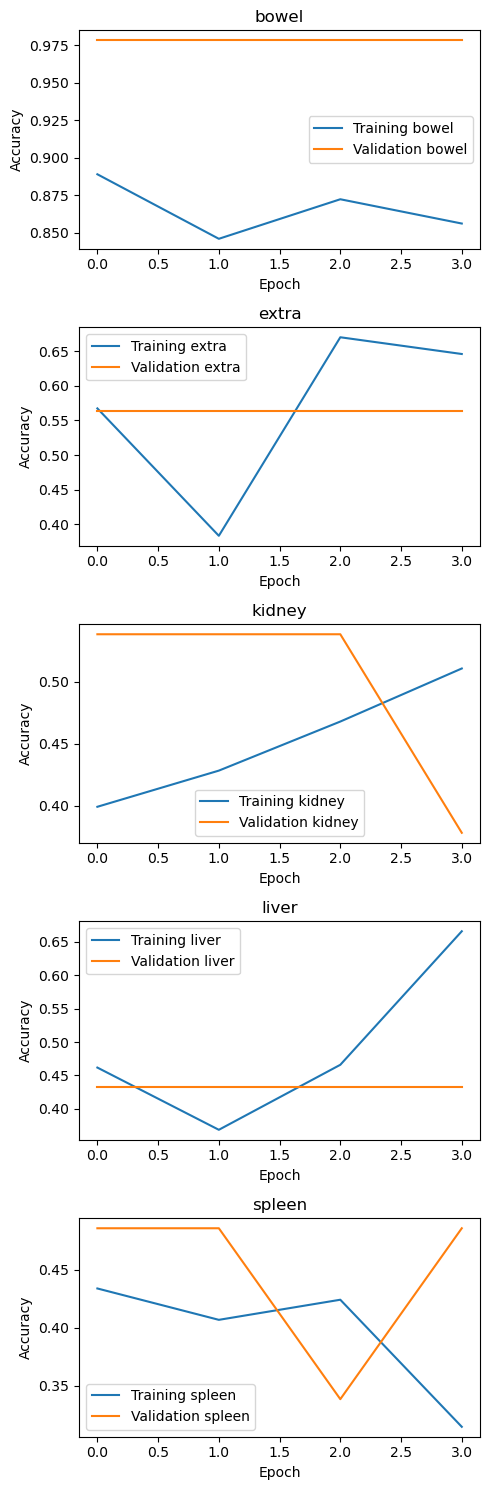

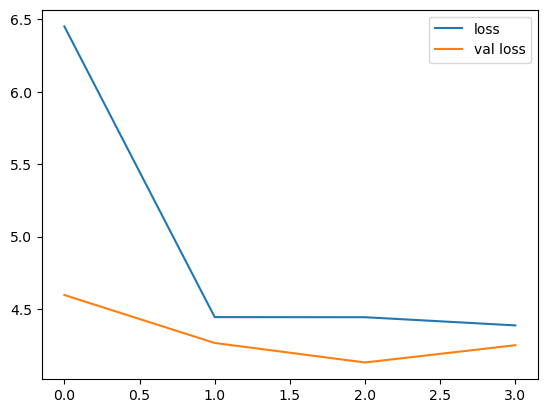

In [6]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [7]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 4.131
>>>> BEST Acc   : 0.570
>>>> BEST Epoch : 2

ORGAN Acc:
  >>>> Bowel           : 0.978
  >>>> Extravasation   : 0.563
  >>>> Liver           : 0.433
  >>>> Kidney          : 0.538
  >>>> Spleen          : 0.338


In [8]:
# Save the model
model.save("rsna-atd.keras")

In [9]:
def post_proc(pred):
    proc_pred = np.empty((len(pred[0]), 2*2 + 3*3), dtype="float32")

    # bowel, extravasation
    proc_pred[:,0] = np.transpose(np.array(pred[:][0]))
    proc_pred[:, 1] = 1 - proc_pred[:, 0]
    proc_pred[:, 2] = np.transpose(np.array(pred[:][1]))
    proc_pred[:, 3] = 1 - proc_pred[:, 2]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:][2]
    proc_pred[:, 7:10] = pred[:][3]
    proc_pred[:, 10:13] = pred[:][4]

    return proc_pred

predictions = pd.DataFrame(post_proc(model.predict(valid_dataset)))
predictions.columns = ORIGINAL_COLS
display(predictions)
validation = pd.DataFrame(valid_labels)
validation.columns = TARGET_COLS
validation['bowel_healthy'] = 1 - validation['bowel_injury']
validation['any_injury'] = 1
validation['extravasation_healthy'] = 1 - validation['extravasation_injury']
display(validation)


45/45 [==============================] - 4s 78ms/step


,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,0.306288,0.693712,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
1,0.303218,0.696782,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
2,0.298639,0.701361,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
3,0.293789,0.706211,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
4,0.289740,0.710260,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,0.299346,0.700654,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
1426,0.300005,0.699995,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
1427,0.299884,0.700116,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671
1428,0.300658,0.699342,0.493514,0.506486,0.357442,0.317823,0.324734,0.346138,0.340183,0.313679,0.334022,0.328306,0.337671


,bowel_injury,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,bowel_healthy,any_injury,extravasation_healthy
0,0,0,0,0,1,0,1,0,1,0,0,1,1,1
1,0,0,0,0,1,0,1,0,1,0,0,1,1,1
2,0,0,0,0,1,0,1,0,1,0,0,1,1,1
3,0,0,0,0,1,0,1,0,1,0,0,1,1,1
4,0,0,0,0,1,0,1,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,0,0,0,1,0,0,0,1,1,0,0,1,1,1
1426,0,0,0,1,0,0,0,1,1,0,0,1,1,1
1427,0,0,0,1,0,0,0,1,1,0,0,1,1,1
1428,0,0,0,1,0,0,0,1,1,0,0,1,1,1


# [Score](https://www.kaggle.com/code/jakebrusca/rsna23-weighted-mean-baseline)

In [10]:
"""
# List of Targets
Injuries = ['bowel_healthy', 'bowel_injury', 
            'extravasation_healthy', 'extravasation_injury', 
            'kidney_healthy', 'kidney_low', 'kidney_high', 
            'liver_healthy', 'liver_low', 'liver_high', 
            'spleen_healthy', 'spleen_low', 'spleen_high', 
            'any_injury']

# Group by different sample weights
scale_by_2 = ['bowel_injury','kidney_low','liver_low','spleen_low']
scale_by_4 = ['kidney_high','liver_high','spleen_high']
scale_by_6 = ['extravasation_injury','any_injury']

class ParticipantVisibleError(Exception):
    pass

def normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    # Normalize the sum of each row's probabilities to 100%.
    # 0.75, 0.75 => 0.5, 0.5
    # 0.1, 0.1 => 0.5, 0.5
    row_totals = df[group_columns].sum(axis=1)
    if row_totals.min() == 0:
        raise ParticipantVisibleError('All rows must contain at least one non-zero prediction')
    for col in group_columns:
        df[col] /= row_totals
    return df


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Pseudocode:
    1. For every label group (liver, bowel, etc):
        - Normalize the sum of each row's probabilities to 100%.
        - Calculate the sample weighted log loss.
    2. Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    3. Calculate the sample weighted log loss for the new label group
    4. Return the average of all of the label group log losses as the final score.
    '''
    print(type(solution))
    #del solution[row_id_column_name]
    #del submission[row_id_column_name]

    # Run basic QC checks on the inputs
    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission.values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution.min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission.min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    # Calculate the label group log losses
    binary_targets = ['bowel', 'extravasation']
    triple_level_targets = ['kidney', 'liver', 'spleen']
    all_target_categories = binary_targets + triple_level_targets

    label_group_losses = []
    for category in all_target_categories:
        if category in binary_targets:
            col_group = [f'{category}_healthy', f'{category}_injury']
        else:
            col_group = [f'{category}_healthy', f'{category}_low', f'{category}_high']

        solution = normalize_probabilities_to_one(solution, col_group)

        for col in col_group:
            if col not in submission.columns:
                raise ParticipantVisibleError(f'Missing submission column {col}')
        submission = normalize_probabilities_to_one(submission, col_group)
        label_group_losses.append(
            sklearn.metrics.log_loss(
                y_true=solution[col_group].values,
                y_pred=submission[col_group].values,
                sample_weight=solution[f'{category}_weight'].values
            )
        )

    # Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    healthy_cols = [x + '_healthy' for x in all_target_categories]
    any_injury_labels = (1 - solution[healthy_cols]).max(axis=1)
    display(any_injury_labels)
    any_injury_predictions = (1 - submission[healthy_cols]).max(axis=1)
    any_injury_loss = sklearn.metrics.log_loss(
        y_true=any_injury_labels.values,
        y_pred=any_injury_predictions.values,
        sample_weight=solution['any_injury_weight'].values
    )

    label_group_losses.append(any_injury_loss)
    return np.mean(label_group_losses)

# Assign the appropriate weights to each category
def create_training_solution(y_train):
    sol_train = y_train.copy()
    
    # bowel healthy|injury sample weight = 1|2
    sol_train['bowel_weight'] = np.where(sol_train['bowel_injury'] == 1, 2, 1)
    
    # extravasation healthy/injury sample weight = 1|6
    sol_train['extravasation_weight'] = np.where(sol_train['extravasation_injury'] == 1, 6, 1)
    
    # kidney healthy|low|high sample weight = 1|2|4
    sol_train['kidney_weight'] = np.where(sol_train['kidney_low'] == 1, 2, np.where(sol_train['kidney_high'] == 1, 4, 1))
    
    # liver healthy|low|high sample weight = 1|2|4
    sol_train['liver_weight'] = np.where(sol_train['liver_low'] == 1, 2, np.where(sol_train['liver_high'] == 1, 4, 1))
    
    # spleen healthy|low|high sample weight = 1|2|4
    sol_train['spleen_weight'] = np.where(sol_train['spleen_low'] == 1, 2, np.where(sol_train['spleen_high'] == 1, 4, 1))
    
    # any healthy|injury sample weight = 1|6
    sol_train['any_injury_weight'] = np.where(sol_train['any_injury'] == 1, 6, 1)
    return sol_train

# Update scale factors to improve score
sf_2 = 2
sf_4 = 4
sf_6 = 14

# The score function deletes the ID column so we remake it
solution_train = create_training_solution(validation)

# Reset the prediction, again
predictions = validation.copy()
predictions[Injuries] = validation[Injuries].mean().tolist()

# Scale each target 
predictions[scale_by_2] *=sf_2
predictions[scale_by_4] *=sf_4
predictions[scale_by_6] *=sf_6

improved_scale_score = score(solution_train,predictions,'patient_id')
print(f'Training score with better scaling: {improved_scale_score}')

#val_score = score(solution = validation, submission = predictions, row_id_column_name = 'patient_id')

"""

"\n# List of Targets\nInjuries = ['bowel_healthy', 'bowel_injury', \n            'extravasation_healthy', 'extravasation_injury', \n            'kidney_healthy', 'kidney_low', 'kidney_high', \n            'liver_healthy', 'liver_low', 'liver_high', \n            'spleen_healthy', 'spleen_low', 'spleen_high', \n            'any_injury']\n\n# Group by different sample weights\nscale_by_2 = ['bowel_injury','kidney_low','liver_low','spleen_low']\nscale_by_4 = ['kidney_high','liver_high','spleen_high']\nscale_by_6 = ['extravasation_injury','any_injury']\n\nclass ParticipantVisibleError(Exception):\n    pass\n\ndef normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:\n    # Normalize the sum of each row's probabilities to 100%.\n    # 0.75, 0.75 => 0.5, 0.5\n    # 0.1, 0.1 => 0.5, 0.5\n    row_totals = df[group_columns].sum(axis=1)\n    if row_totals.min() == 0:\n        raise ParticipantVisibleError('All rows must contain at least one non-zero prediction')\

# Credits 

https://www.kaggle.com/code/metric/rsna-trauma-metric/notebook

https://keras.io/examples/keras_recipes/tfrecord/

https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays

https://www.kaggle.com/code/aritrag/kerascv-starter-notebook-infer

https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation